In [2]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import math
from collections import defaultdict
import operator
import heapq

%matplotlib inline

In [3]:
check_imgs = ["camera_cal/calibration"+str(i)+".jpg" for i in range(1,21)]
grid_sizes = [(9,5),(9,6),(9,6),(6,5),(7,6)]+ [(9,6)]*15

def calibration_matrix(imgs, grid_sizes):
    objpoints = []
    imgpoints = []
    for idx, fname in enumerate(imgs):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grid_size = grid_sizes[idx]
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, grid_size, None)

        # If found, add object points, image points
        if ret == True:
            objp = np.zeros((grid_size[0]*grid_size[1],3), np.float32)
            objp[:,:2] = np.mgrid[0:grid_size[0], 0:grid_size[1]].T.reshape(-1,2)

            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
#             cv2.drawChessboardCorners(img, grid_size, corners, ret)
#             write_name = 'camera_cal/corners_found'+str(idx+1)+'.jpg'
#             cv2.imwrite(write_name, img)
    #         cv2.imshow('img', img)
    #         cv2.waitKey(500)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return (mtx,dist)

In [4]:
mtx, dist = calibration_matrix(check_imgs,grid_sizes)

In [5]:
cv2.__version__

'3.1.0'

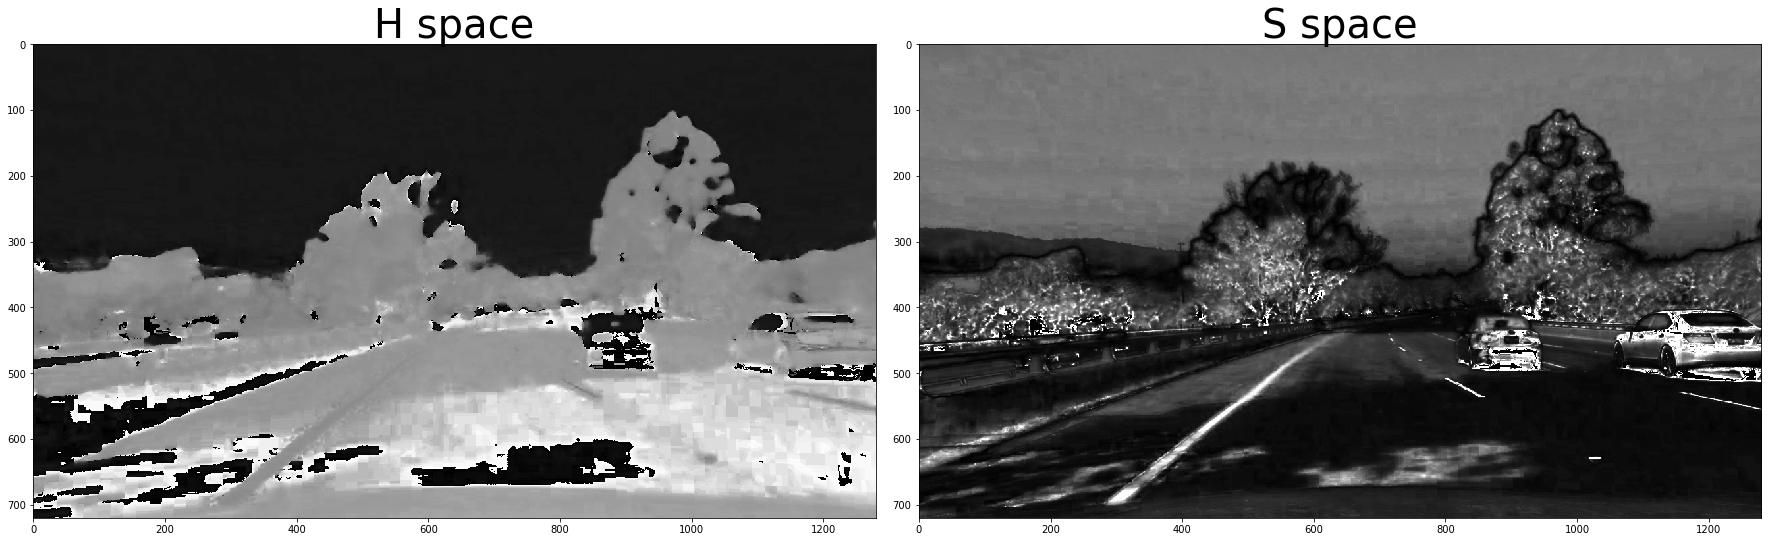

In [6]:
warped = cv2.undistort(cv2.imread('test_images/test4.jpg'), mtx, dist, None, mtx)

# Convert to HLS color space and separate the V channel
hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS).astype(np.float)# plt.imshow(result[:,:,2])
# Plot the result
# print(np.min(hls[:,:,1]),np.max(hls[:,:,1]))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(hls[:,:,0], cmap=cm.gray)
ax1.set_title('H space', fontsize=40)
ax2.imshow(hls[:,:,2], cmap=cm.gray)
ax2.set_title('S space', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [7]:
white = np.uint8([[[25, 25, 25]]])
cv2.cvtColor(white, cv2.COLOR_RGB2HLS).astype(np.float)

array([[[  0.,  25.,   0.]]])

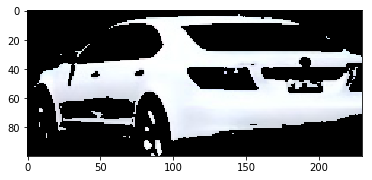

In [55]:

masked = warped.copy()
masked[:,:,0][(warped[:,:,0]<210) | (warped[:,:,1]<210) | (warped[:,:,2]<210)] =0
masked[:,:,1][(warped[:,:,0]<210) | (warped[:,:,1]<210) | (warped[:,:,2]<210)] =0
masked[:,:,2][(warped[:,:,0]<210) | (warped[:,:,1]<210) | (warped[:,:,2]<210)] =0

plt.imshow(masked[400:500,1050:,:])

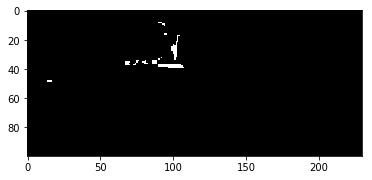

In [68]:
white_blobs = np.zeros_like(warped[:,:,1])
white_blobs[(warped[:,:,0]==255) & (warped[:,:,1]==255) & (warped[:,:,2]==255)] =1
plt.imshow(white_blobs[400:500,1050:], cmap=cm.gray)

In [57]:
tmp = masked[400:500,1050:,:]
tmp[60,100,:]

array([245, 253, 255], dtype=uint8)

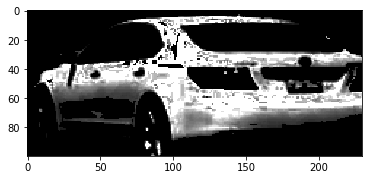

In [60]:
testhls = cv2.cvtColor(tmp, cv2.COLOR_RGB2HLS).astype(np.float)
plt.imshow(testhls[:,:,2]/255, cmap=cm.gray)

In [8]:
def pipeline(img, mtx, dist, s_thresh=(10, 95), 
             h_thresh=(18, 25), ang_thresh=(0.5, math.pi/2),
             ksize=3):
    r_channel = img[:,:,2]
    img = cv2.undistort(img, mtx, dist, None, mtx)

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]
    
    # Threshold hue channel, filter only yellow and white
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel>h_thresh[0]) & (h_channel<=h_thresh[1])] = 1
       
    # Sobel
    sobelx = cv2.Sobel(h_channel, cv2.CV_64F, 1, 0, ksize=ksize) # Take the derivative in x
    sobely = cv2.Sobel(h_channel, cv2.CV_64F, 0, 1, ksize=ksize) # Take the derivative in y
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate lines away from horizontal
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    mg = np.sqrt(np.square(abs_sobelx)+np.square(abs_sobely))
    mg = np.int8(mg*255/np.max(mg))
    
    angle = np.arctan2(abs_sobely, abs_sobelx)

    # Threshold x gradient
#     sxbinary = np.zeros_like(scaled_sobelx)
#     sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])
#              & (angle>ang_thresh[0]) & (angle<=ang_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) | s_channel==0] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(h_binary), h_binary, s_binary))
    return color_binary
    
img = cv2.imread('test_images/test4.jpg')
result = pipeline(img, mtx, dist, s_thresh=(150, 255))
# plt.imshow(result[:,:,2])
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(result[:,:,1], cmap=cm.gray)
ax1.set_title('H space', fontsize=40)
result[100:800,50:100,:] = 0
result[900:1000,50:100,:] = 255
ax2.imshow(result[:,:,2], cmap=cm.gray)
ax2.set_title('S space', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

TypeError: ufunc 'bitwise_or' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Computer Perspective Tranformation

In [9]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [10]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sb = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sb = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sb = np.absolute(sb)
    sc_sb = np.uint8(abs_sb*255/np.max(abs_sb))
    binary_output = np.zeros_like(sc_sb)
    binary_output[(sc_sb>thresh_min)&(sc_sb<thresh_max)]=1
    return binary_output

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [12]:
def get_channel(image, i):
    return np.dstack(( image[:,:,i], image[:,:,i], image[:,:,i]))
def get_red(img):
    return get_channel(img,0)
def get_green(img):
    return get_channel(img,1)
def get_blue(img):
    return get_channel(img,2)

def get_hue(image):
    h = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float)[:,:,0]
    print(h[523,833])
    print(h[523,832])
    print(h[523,831])
    return np.dstack((h,h,h))

def get_saturation(image):
    s = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float)[:,:,1]
    return np.dstack((s, s, s))

In [13]:
def get_yellow(img):
    y = (img[:,:,0].astype(np.float)+img[:,:,1].astype(np.float))/2
    return np.dstack((y, y, y))

In [14]:
def get_channel_eq(image, i):
    tmp = cv2.equalizeHist(image[:,:,i])
    return np.dstack((tmp, tmp, tmp))
def get_red_eq(img):
    return get_channel(img,0)
def get_green_eq(img):
    return get_channel(img,1)
def get_blue_eq(img):
    return get_channel(img,2)

def get_hue_eq(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    tmp = cv2.equalizeHist(hsv[:,:,0])
    return np.dstack((tmp, tmp, tmp))

def get_saturation_eq(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    tmp = cv2.equalizeHist(hsv[:,:,2])
    return np.dstack((tmp, tmp, tmp))

In [15]:
im = mpimg.imread('test_images/test4.jpg')
v = cv2.cvtColor(im, cv2.COLOR_RGB2HSV).astype(np.float)[:,:,2]
print(np.max(v),np.min(v))

255.0 0.0


In [16]:
def hue_filter(img, h_thresh=(19,19)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    h_channel = hsv[:,:,0]
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel>=h_thresh[0]) & (h_channel<=h_thresh[1])] = 1
    return np.dstack((h_binary,h_binary,h_binary))*255.0

In [301]:
input_vid = 'harder_challenge_video.mp4'
clip2 = VideoFileClip(input_vid)

challenge_output = (input_vid[:-4]+'_yellow.mp4')
challenge_clip = clip2.fl_image(get_yellow)
%time challenge_clip.write_videofile(challenge_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

[MoviePy] >>>> Building video harder_challenge_video_yellow.mp4
[MoviePy] Writing video harder_challenge_video_yellow.mp4


100%|█████████▉| 1199/1200 [00:38<00:00, 32.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_yellow.mp4 

CPU times: user 22.6 s, sys: 9.71 s, total: 32.3 s
Wall time: 39.3 s


In [175]:
input_vid = 'challenge_video.mp4'
clip2 = VideoFileClip(input_vid)
func_list = {
#              "hue_filter": (lambda x:hue_filter(x)),
#              "saturation_filter": (lambda x:saturation_filter(x)),
#              "get_red_eq": (lambda x:get_red_eq(x)), 
#              "get_green_eq": (lambda x:get_green_eq(x)),
#              "get_blue_eq": (lambda x:get_blue_eq(x)),
             "get_hue": (lambda x:get_hue(x)),
             "get_saturation": (lambda x:get_saturation(x)),
#              "get_hue_eq": (lambda x:get_hue_eq(x)),
#              "get_saturation_eq": (lambda x:get_saturation_eq(x))
            }

for k in func_list:
    print(k)
    challenge_output = (input_vid[:-4]+'_'+k+'.mp4' if ("filter" in k) 
                        else input_vid[:-4]+'_'+k.split('_')[-1]+'.mp4')
    challenge_clip = clip2.fl_image(func_list[k])
    %time challenge_clip.write_videofile(challenge_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

get_hue
[MoviePy] >>>> Building video challenge_video_hue.mp4
[MoviePy] Writing video challenge_video_hue.mp4


100%|██████████| 485/485 [00:14<00:00, 37.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_hue.mp4 

CPU times: user 13 s, sys: 5.38 s, total: 18.3 s
Wall time: 15.2 s
get_saturation
[MoviePy] >>>> Building video challenge_video_saturation.mp4
[MoviePy] Writing video challenge_video_saturation.mp4


100%|██████████| 485/485 [00:16<00:00, 29.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_saturation.mp4 

CPU times: user 14.4 s, sys: 5.82 s, total: 20.2 s
Wall time: 17.2 s


In [17]:
def sob_filter(channel, x_thresh=(0.8,1), y_thresh=(0,1), 
               a_thresh=(0.01,1.56), grad_thresh=(0,1), ksize=9):
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=ksize) # Take the derivative in x
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=ksize) # Take the derivative in y
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = abs_sobelx/np.max(abs_sobelx)
    abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate lines away from horizontal
    scaled_sobely = abs_sobely/np.max(abs_sobely)
    
    mg = np.sqrt(np.square(abs_sobelx)+np.square(abs_sobely))
    mg = mg/np.max(mg)
    
    angle = np.arctan2(abs_sobely, abs_sobelx)

    h_binary = np.zeros_like(h_channel)
    h_binary[(scaled_sobelx>=x_thresh[0]) &
             (scaled_sobelx<=x_thresh[1]) &
             (scaled_sobely>=y_thresh[0]) & 
             (scaled_sobely<=y_thresh[1]) &
             (mg>=grad_thresh[0]) &
             (mg<=grad_thresh[1]) &
             (angle>=a_thresh[0]) & 
             (angle<=a_thresh[1])] = 1
    return np.dstack((h_binary,h_binary,h_binary))*255.0

In [307]:
input_vid = 'harder_challenge_video.mp4'
clip2 = VideoFileClip(input_vid)
par_sob_filter = lambda x:sob_filter(cv2.GaussianBlur(x[:,:,0],(5,5),0),
                                  x_thresh=(0.8,1), y_thresh=(0,0.1), 
                                  a_thresh=(0.01,1.56), grad_thresh=(0,1), ksize=9)

challenge_output = (input_vid[:-4]+'_sob.mp4')
challenge_clip = clip2.fl_image(sob_filter)
%time challenge_clip.write_videofile(challenge_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

[MoviePy] >>>> Building video harder_challenge_video_sob.mp4
[MoviePy] Writing video harder_challenge_video_sob.mp4


100%|█████████▉| 1199/1200 [06:24<00:00,  3.24it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_sob.mp4 

CPU times: user 4min 51s, sys: 1min 22s, total: 6min 14s
Wall time: 6min 24s


In [18]:
def bump_filter(img, thresh=(0.5,1), ksize=3):
    kernel = np.array([[-1]*ksize+[2]*ksize+[-1]*ksize for i in range(1)])
    res = np.abs(cv2.filter2D(img, -1, kernel))
    res = res/np.max(res)
    binary = np.zeros_like(res)
    binary[(res>=thresh[0])&(res<=thresh[1])] = 1
    return binary*255.0 if len(binary.shape)==3 else np.dstack((binary,binary,binary))*255.0

In [19]:
def parabolic_bump_filter(img, thresh=(0.5,1), ksize=3):
    kernel = np.array([[-1]*ksize+[2]*ksize+[-1]*ksize])
    res = np.abs(cv2.filter2D(img, -1, kernel))
    res = res/np.max(res)
    y_kernel = np.array([[-1],[-1],[0],[1],[1]])
    mask = np.abs(cv2.filter2D(img, -1, y_kernel))
    binary = np.zeros_like(res)
    binary[(res>=thresh[0])&(res<=thresh[1])&(mask<0.0001)] = 1
    return binary*255.0 if len(binary.shape)==3 else np.dstack((binary,binary,binary))*255.0

In [20]:
def topo_parabolic_bump_filter(img, x_thresh=(0.5,1), 
                               y_thresh=(0,0.0001), 
                               min_area=400, ksize=3):
    kernel = np.array([[-1]*ksize+[2]*ksize+[-1]*ksize])
    res = np.abs(cv2.filter2D(img, -1, kernel))
    res = res/np.max(res)
    y_kernel = np.array([[-1],[-1],[0],[1],[1]])
    mask = np.abs(cv2.filter2D(img, -1, y_kernel))
    binary = np.zeros_like(res)
    binary[(res>=x_thresh[0])&(res<=x_thresh[1])&(mask<y_thresh[1])] = 1
    d_kernel = np.ones((3,3),np.uint8)
    binary = cv2.dilate(binary,d_kernel,iterations = 1)
    binary = cv2.erode(binary,d_kernel,iterations = 1)
    
    n,n_blobs,stats,cent = cv2.connectedComponentsWithStats(binary.astype(np.uint8),
                                                            connectivity=8,ltype=cv2.CV_32S)
    tot = img.shape[0]*img.shape[1]
    areas = stats[:,-1]
    
#     big_segs = np.where((areas<tot/10)&(areas>min_area))[0]
    big_segs = heapq.nlargest(6, range(len(areas)), areas.take)
    binary = np.zeros_like(res)
    for i in big_segs[1:]:
        binary[n_blobs==i]=1
    return binary*255.0 if len(binary.shape)==3 else np.dstack((binary,binary,binary))*255.0

In [21]:
input_vid = 'challenge_video.mp4'
clip2 = VideoFileClip(input_vid)
red_topo_para_bump_filter = lambda x:topo_parabolic_bump_filter(cv2.GaussianBlur(x[:,:,0],(5,5),0),
                                                                x_thresh=(0.9,1), min_area=1000, ksize=15)
red_para_bump_filter = lambda x:parabolic_bump_filter(cv2.GaussianBlur(x[:,:,0],(5,5),0),thresh=(0.9,1), ksize=10)
green_bump_filter = lambda x:bump_filter(x[:,:,1])
blue_bump_filter = lambda x:bump_filter(x[:,:,2])
yellow_bump_filter = lambda x:bump_filter((x[:,:,0].astype(np.float)+x[:,:,1].astype(np.float))/2.0,
                                          thresh=(0.9,1), ksize=10)
yellow_para_bump_filter = lambda x:parabolic_bump_filter((x[:,:,0].astype(np.float)+x[:,:,1].astype(np.float))/2.0,
                                                         thresh=(0.4,1), ksize=10)

challenge_output = (input_vid[:-4]+'_red_topo_para_blur_k15_thres90_6area_dilate.mp4')
challenge_clip = clip2.fl_image(red_topo_para_bump_filter)
%time challenge_clip.write_videofile(challenge_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

[MoviePy] >>>> Building video challenge_video_red_topo_para_blur_k15_thres90_6area_dilate.mp4
[MoviePy] Writing video challenge_video_red_topo_para_blur_k15_thres90_6area_dilate.mp4


100%|██████████| 485/485 [00:27<00:00, 18.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_red_topo_para_blur_k15_thres90_6area_dilate.mp4 

CPU times: user 22.2 s, sys: 4.54 s, total: 26.7 s
Wall time: 27.4 s


In [361]:
def saturation_filter(img, s_thresh=(1, 2)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    s_channel = hsv[:,:,1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel>=s_thresh[0]) & (s_channel<=s_thresh[1])] = 1
    return np.dstack((s_binary,s_binary,s_binary))*255.0

In [365]:
input_vid = 'project_video.mp4'
clip2 = VideoFileClip(input_vid)
par = (1,2)
fil = lambda x:saturation_filter(x, s_thresh=par)

challenge_output = (input_vid[:-4]+'_hsv_saturation_'+str(par[0])+'_'+str(par[1])+'.mp4')
challenge_clip = clip2.fl_image(fil)
%time challenge_clip.write_videofile(challenge_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

[MoviePy] >>>> Building video project_video_hsv_saturation_1_2.mp4
[MoviePy] Writing video project_video_hsv_saturation_1_2.mp4


100%|█████████▉| 1260/1261 [00:22<00:00, 55.50it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_hsv_saturation_1_2.mp4 



CPU times: user 28.8 s, sys: 6.62 s, total: 35.4 s
Wall time: 22.8 s


In [367]:
def light_filter(img, s_thresh=(200, 255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel>=s_thresh[0]) & (v_channel<=s_thresh[1])] = 1
    return np.dstack((v_binary,v_binary,v_binary))*255.0

In [368]:
input_vid = 'project_video.mp4'
clip2 = VideoFileClip(input_vid)

challenge_output = (input_vid[:-4]+'_hsv_value_200_255.mp4')
challenge_clip = clip2.fl_image(light_filter)
%time challenge_clip.write_videofile(challenge_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

[MoviePy] >>>> Building video project_video_hsv_value_200_255.mp4
[MoviePy] Writing video project_video_hsv_value_200_255.mp4


100%|█████████▉| 1260/1261 [00:25<00:00, 44.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_hsv_value_200_255.mp4 

CPU times: user 30 s, sys: 7.84 s, total: 37.9 s
Wall time: 25.7 s


In [197]:
green = np.uint8([[[255,250,255 ]]])
hsv_green = cv2.cvtColor(green,cv2.COLOR_BGR2HSV)
print(hsv_green)

[[[150   5 255]]]


In [111]:
def red_filter(img, r_thresh=(115, 150)):
    r_channel = img[:,:,0]
    
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel>r_thresh[0]) & (r_channel<=r_thresh[1])] = 1
    return np.dstack((r_binary,r_binary,r_binary))*255.0

In [112]:
input_vid = 'challenge_video.mp4'
clip2 = VideoFileClip(input_vid)

challenge_output = (input_vid[:-4]+'_red_115_150.mp4')
challenge_clip = clip2.fl_image(red_filter)
%time challenge_clip.write_videofile(challenge_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

[MoviePy] >>>> Building video challenge_video_red_115_150.mp4
[MoviePy] Writing video challenge_video_red_115_150.mp4


100%|██████████| 485/485 [00:09<00:00, 53.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_red_115_150.mp4 

CPU times: user 6.05 s, sys: 2.25 s, total: 8.31 s
Wall time: 9.68 s


In [360]:
def light_filter(img, v_thresh=(70, 110)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hsv[:,:,2]
    
    v_binary = np.zeros_like(s_channel)
    v_binary[(v_channel>v_thresh[0]) & (v_channel<=v_thresh[1])] = 1
    return np.dstack((v_binary,v_binary,v_binary))*255.0

In [104]:
input_vid = 'challenge_video.mp4'
clip2 = VideoFileClip(input_vid)

challenge_output = (input_vid[:-4]+'light_70_110.mp4')
challenge_clip = clip2.fl_image(light_filter)
%time challenge_clip.write_videofile(challenge_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

[MoviePy] >>>> Building video challenge_videolight_70_110.mp4
[MoviePy] Writing video challenge_videolight_70_110.mp4


100%|██████████| 485/485 [00:16<00:00, 28.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_videolight_70_110.mp4 

CPU times: user 14.7 s, sys: 6.17 s, total: 20.9 s
Wall time: 17.2 s


In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)